In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
# --- 1. synthetic data with *multiple* blobs and noisy annotators -------------
B, H, W = 4, 128, 128
yy, xx  = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')

# ground-truth centres & radii
centers = [(32, 32), (96, 40), (64, 96)]
radii   = [14, 18, 10]

# -------- correct: build TRUE mask as bool -----------------------------------
true_mask = torch.zeros(H, W, dtype=torch.bool)
for (cy, cx), r in zip(centers, radii):
    true_mask |= (yy - cy)**2 + (xx - cx)**2 < r**2        # bool OR
true_mask = true_mask.float()                              # convert once

# -------- helper returns bool, then casts ------------------------------------
def jitter_blobs(mask_bool, shift_px=2, radius_jitter=2, drop_prob=0.15):
    noisy = torch.zeros_like(mask_bool, dtype=torch.bool)
    for (cy, cx), r in zip(centers, radii):
        dy, dx = torch.randint(-shift_px, shift_px + 1, (2,))
        r2 = max(4, r + torch.randint(-radius_jitter, radius_jitter + 1, ()))
        if torch.rand(1).item() < drop_prob:
            continue
        blob = (yy - (cy + dy))**2 + (xx - (cx + dx))**2 < r2**2
        noisy |= blob                                         # safe: bool
    # salt-and-pepper
    # salt-and-pepper noise — now dtype=float so uniform() is valid
        noisy ^= (torch.rand_like(noisy, dtype=torch.float32) < 0.02)

    return noisy.float()                                      # return float

ann1 = jitter_blobs(true_mask.bool(), shift_px=1, radius_jitter=1, drop_prob=0.05)
ann2 = jitter_blobs(true_mask.bool(), shift_px=3, radius_jitter=3, drop_prob=0.10)
ann3 = jitter_blobs(true_mask.bool(), shift_px=4, radius_jitter=4, drop_prob=0.25)

# -------- stack & consensus ---------------------------------------------------
y_stack = torch.stack([ann1, ann2, ann3])          # 3, H, W   (float 0/1)
y_cons  = y_stack.mean(0, keepdim=True)   

step 000  loss 0.7726
step 060  loss 0.1653
step 120  loss 0.1268
step 180  loss 0.1214
step 240  loss 0.1191


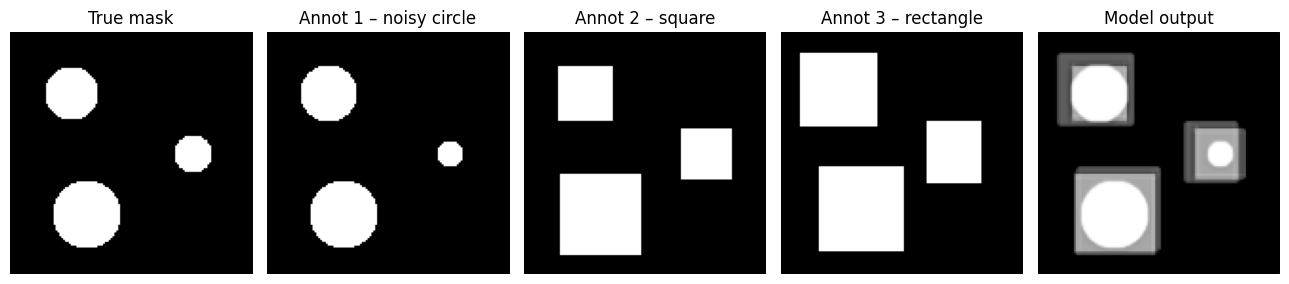

In [18]:
# ========================================================
# 0. imports & helpers
# ========================================================
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --------------------------------------------------------
# 1. synthetic data with blobs + 3 very different annotators
# --------------------------------------------------------
B, H, W = 4, 128, 128
yy, xx  = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')

# ground-truth = perfect circles
centers = [(32, 32), (96, 40), (64, 96)]
radii   = [14, 18, 10]

true_mask = torch.zeros(H, W, dtype=torch.bool)
for (cy, cx), r in zip(centers, radii):
    true_mask |= (yy - cy)**2 + (xx - cx)**2 < r**2
true_mask = true_mask.float()

# ----- annotator 1 – noisy circles -------------------------------------------
def anno1_circle_noise():
    m = torch.zeros_like(true_mask, dtype=torch.bool)
    for (cy, cx), r in zip(centers, radii):
        r2 = max(4, r + torch.randint(-3, 4, ()))        # ±3 px radius jitter
        m |= (yy - cy)**2 + (xx - cx)**2 < r2**2
    return m.float()

# ----- annotator 2 – squares --------------------------------------------------
def anno2_squares():
    m = torch.zeros_like(true_mask, dtype=torch.bool)
    for (cy, cx), r in zip(centers, radii):
        d = r + torch.randint(0, 4, ())                  # square half-size
        m[cy-d: cy+d+1, cx-d: cx+d+1] = True
    return m.float()

# ----- annotator 3 – shifted rectangles --------------------------------------
def anno3_rectangles():
    m = torch.zeros_like(true_mask, dtype=torch.bool)
    for (cy, cx), r in zip(centers, radii):
        h = r + torch.randint(3, 8, ())                  # random height
        w = r + torch.randint(3, 8, ())                  # random width
        dy, dx = torch.randint(-6, 7, (2,))              # centre shift
        ys, xs = cy+dy-h, cx+dx-w
        ye, xe = cy+dy+h, cx+dx+w
        ys, xs = max(0, ys), max(0, xs)
        ye, xe = min(H-1, ye), min(W-1, xe)
        m[ys:ye+1, xs:xe+1] = True
    return m.float()

ann1 = anno1_circle_noise()
ann2 = anno2_squares()
ann3 = anno3_rectangles()

# ---------- batch-stack -------------------------------------------------------
y_stack = torch.stack([ann1, ann2, ann3]).repeat(B, 1, 1, 1)  # B,3,H,W
y_cons  = y_stack.mean(1, keepdim=True)                       # B,1,H,W

# --------------------------------------------------------
# 2. simple feature-extract-and-fuse network
# --------------------------------------------------------
class SubEnc(nn.Module):
    def __init__(self, hidden=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, hidden, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class FuseNet(nn.Module):
    def __init__(self, n_ann=3, hidden=8):
        super().__init__()
        self.br = nn.ModuleList([SubEnc(hidden) for _ in range(n_ann)])
        self.fuse = nn.Sequential(
            nn.Conv2d(hidden*n_ann, hidden*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden*2, 1, 1)     # 1-channel logit map
        )
    def forward(self, y):
        feats = [b(y[:, i:i+1]) for i, b in enumerate(self.br)]
        return self.fuse(torch.cat(feats, dim=1))

net  = FuseNet().to(device)
opt  = torch.optim.Adam(net.parameters(), 1e-3)
crit = nn.BCEWithLogitsLoss()

# --------------------------------------------------------
# 3. quick training loop (300 steps)
# --------------------------------------------------------
for step in range(300):
    opt.zero_grad()
    logit = net(y_stack.to(device))
    loss  = crit(logit, y_cons.to(device))
    loss.backward(); opt.step()
    if step % 60 == 0:
        print(f"step {step:03d}  loss {loss.item():.4f}")

# --------------------------------------------------------
# 4. visualize one batch sample
# --------------------------------------------------------
with torch.no_grad():
    idx   = 0
    pred  = torch.sigmoid(net(y_stack.to(device))[idx,0]).cpu() 
    imgs  = [true_mask, ann1, ann2, ann3, pred]
    titles= ['True mask','Annot 1 – noisy circle','Annot 2 – square',
             'Annot 3 – rectangle','Model output']
    plt.figure(figsize=(13,3))
    for i,(im,tt) in enumerate(zip(imgs,titles)):
        plt.subplot(1,5,i+1); plt.imshow(im,cmap='gray'); plt.title(tt); plt.axis('off')
    plt.tight_layout(); plt.show()


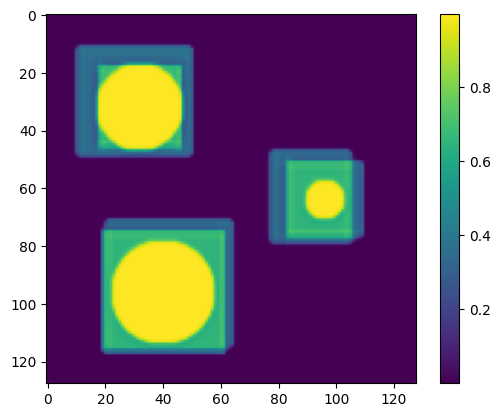

In [21]:
plt.imshow(pred)
plt.colorbar()

In [22]:
import glob, re, xarray as xr, torch
from pathlib import Path
from torch.utils.data import Dataset

class ARMultiAnnDataset(Dataset):
    def __init__(self, folder, var_names, transform=None):
        self.folder     = Path(folder)
        self.var_names  = var_names          # list like ["IVT", "IWV", ...]
        self.transform  = transform

        # 1) group nc files by date (regex grabs YYYY-MM-DD)
        patt = re.compile(r"data-(\d{4}-\d{2}-\d{2})-.*?_(\d+)\.nc$")
        by_date = {}
        for f in glob.glob(str(self.folder / "*.nc")):
            m = patt.search(Path(f).name)
            if not m: continue
            date_key  = m.group(1)
            ann_idx   = int(m.group(2))
            by_date.setdefault(date_key, {})[ann_idx] = f
        self.samples = list(by_date.items())   # [(date, {ann: path, ...}), ...]

    def __len__(self): return len(self.samples)

    def _load_nc(self, path):
        ds = xr.open_dataset(path, engine="netcdf4")
        x  = torch.stack([torch.tensor(ds[v].values) for v in self.var_names]) # C,H,W
        y  = torch.tensor(ds["LABELS"].values).unsqueeze(0)                    # 1,H,W
        ds.close()
        return x.float(), y.float()

    def __getitem__(self, idx):
        date, ann_dict = self.samples[idx]

        xs, ys = [], []
        for p in ann_dict.values():                       # iterate annotators
            x, y = self._load_nc(p)
            xs.append(x)          # they’re identical across annotators → keep one
            ys.append(y)
        x  = xs[0]                                    # choose variables once
        y_stack = torch.cat(ys, dim=0)                # N,H,W
        y_cons  = y_stack.mean(0, keepdim=True)       # 1,H,W

        if self.transform:
            x, y_stack, y_cons = self.transform(x, y_stack, y_cons)
        return x, y_stack, y_cons


In [27]:
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import random # optional mixed precision

device  = "cuda" if torch.cuda.is_available() else "cpu"
vars_   = ["TMQ"]           # 16 variable names in .nc
ds      = ARMultiAnnDataset("/home/sbk29/data/AR/train", vars_)
loader  = DataLoader(ds, batch_size=2, shuffle=True, num_workers=8)

In [46]:
for idx in random.sample(range(len(ds_var)), 10):
    x, y_stack, y_cons = ds[idx]
    print(f"Sample #{idx}")
    print("  x        :", x.shape, x.dtype)           # e.g. [16,256,256] float32
    print("  y_stack  :", y_stack.shape, y_stack.dtype,
          " (annotators =", y_stack.shape[0], ")")
    print("  y_cons   :", y_cons.shape, "min/max =", 
          float(y_cons.min()), float(y_cons.max()))
    print("-" * 60)

Sample #91
  x        : torch.Size([1, 1, 768, 1152]) torch.float32
  y_stack  : torch.Size([2, 768, 1152]) torch.float32  (annotators = 2 )
  y_cons   : torch.Size([1, 768, 1152]) min/max = 0.0 2.0
------------------------------------------------------------
Sample #184
  x        : torch.Size([1, 1, 768, 1152]) torch.float32
  y_stack  : torch.Size([1, 768, 1152]) torch.float32  (annotators = 1 )
  y_cons   : torch.Size([1, 768, 1152]) min/max = 0.0 2.0
------------------------------------------------------------
Sample #55
  x        : torch.Size([1, 1, 768, 1152]) torch.float32
  y_stack  : torch.Size([3, 768, 1152]) torch.float32  (annotators = 3 )
  y_cons   : torch.Size([1, 768, 1152]) min/max = 0.0 2.0
------------------------------------------------------------
Sample #69
  x        : torch.Size([1, 1, 768, 1152]) torch.float32
  y_stack  : torch.Size([1, 768, 1152]) torch.float32  (annotators = 1 )
  y_cons   : torch.Size([1, 768, 1152]) min/max = 0.0 2.0
--------------------

In [47]:
print(f"🚀  Found {len(ds_var):,} unique dates with at least one annotator file\n")

🚀  Found 188 unique dates with at least one annotator file



In [48]:
assert torch.allclose(x, ds[idx][0]), "Variables differ across annotator files!"

In [49]:
# ------------------------------------------------------------
# 3. run a quick DataLoader pass
# ------------------------------------------------------------
loader = DataLoader(ds_var, batch_size=2, shuffle=True, num_workers=8, pin_memory=True)

x_b, y_stack_b, y_cons_b = next(iter(loader))
print("Batch shapes:")
print("  x_batch       :", x_b.shape)        # [B, C_in, H, W]
print("  y_stack_batch :", y_stack_b.shape)  # [B, N,     H, W]
print("  y_cons_batch  :", y_cons_b.shape)   # [B, 1,     H, W]

# move one batch through your model if you wish
net = ARFuseNet(c_vars=len(vars_)).to(device).eval()
with torch.no_grad():
    logits = net(x_b.to(device), y_stack_b.to(device))
print("  logits        :", logits.shape, logits.dtype)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sbk29/.conda/envs/turbulence/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/sbk29/.conda/envs/turbulence/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/sbk29/.conda/envs/turbulence/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sbk29/.conda/envs/turbulence/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/home/sbk29/.conda/envs/turbulence/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 207, in collate
    raise RuntimeError("each element in list of batch should be of equal size")
RuntimeError: each element in list of batch should be of equal size


In [36]:
# ---------- tiny encoder for stacked masks (annotator branch) ----------
class AnnEncoder(nn.Module):
    def __init__(self, n_ann, c_out=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(n_ann, 16, 3, 1, 1), nn.ReLU(inplace=True),
            nn.Conv2d(16, c_out, 3, 1, 1), nn.ReLU(inplace=True),
        )
    def forward(self, y): return self.net(y)      # (B, c_out, H, W)

# ---------- fusion head -------------------------------------------------------
class ARFuseNet(nn.Module):
    def __init__(self, c_vars, base=32, c_ann=16):
        super().__init__()
        self.var_enc = VarUNet(c_vars, base)      # returns  base channels
        self.ann_enc = AnnEncoder(n_ann=3, c_out=c_ann)
        self.fuse    = nn.Sequential(
            nn.Conv2d(base + c_ann, base, 3, 1, 1), nn.ReLU(inplace=True),
            nn.Conv2d(base, 1, 1)                  # logits
        )
    def forward(self, x_vars, y_stack):
        f_vars = self.var_enc(x_vars)
        f_ann  = self.ann_enc(y_stack)
        f      = torch.cat([f_vars, f_ann], dim=1)
        return self.fuse(f)                       # B,1,H,W  (raw logits)

In [53]:
# ar_multi_ann_dataset.py
# -----------------------------------------------------------
import re, glob
from pathlib import Path
from typing import List, Tuple, Dict, Optional

import torch
import xarray as xr
from torch.utils.data import Dataset

# ------------------------------------------------------------------
# 1. regex that extracts (date, annotator_id) from your filenames
# ------------------------------------------------------------------
#  └─  data-2000-12-20-01-1_0.nc
#                       ^^^^^^ last '_' then digits then '.nc'
FNAME_RE = re.compile(
    r"data-"                # literal prefix
    r"(\d{4}-\d{2}-\d{2})"  # group 1: YYYY-MM-DD
    r"-.*?_"                # non-greedy up to final underscore
    r"(\d+)"                # group 2: annotator ID
    r"\.nc$"                # literal '.nc' at end
)

# ------------------------------------------------------------------
# 2. the dataset
# ------------------------------------------------------------------
class ARMultiAnnDataset(Dataset):
    """
    Loads Atmospheric-River NetCDF tiles that have multiple annotators.

    Each __getitem__ returns
      x_vars   : torch.FloatTensor [C_in, H, W]          – data variables
      y_list   : list[FloatTensor 1×H×W]  length = N_i   – 1 mask per annotator
      y_cons   : FloatTensor [1, H, W]                   – mean-vote consensus

    If you prefer *fixed* N for batching, set `max_ann > 0` and the class will
    pad / truncate y_list to that length and return a *stack*
      y_stack  : FloatTensor [max_ann, H, W]
    """

    def __init__(
        self,
        root: str | Path,
        var_names: List[str],
        max_ann: int | None = None,         # None → variable-length
        transform=None                      # optional augmentation callable
    ):
        super().__init__()
        self.root       = Path(root)
        self.var_names  = var_names
        self.max_ann    = max_ann
        self.transform  = transform

        # ----------------------------------------------------------
        # Group every .nc in root by date
        # samples -> list[ (date_str, {annot_id : path, ...}) ]
        # ----------------------------------------------------------
        by_date: Dict[str, Dict[int, Path]] = {}
        for f in glob.glob(str(self.root / "*.nc")):
            m = FNAME_RE.search(Path(f).name)
            if not m:
                raise ValueError(f"Filename {f} does not match expected pattern")
            date_key  = m.group(1)          # '2000-12-20'
            annot_id  = int(m.group(2))     # 0,1,2,...
            by_date.setdefault(date_key, {})[annot_id] = Path(f)

        self.samples: List[Tuple[str, Dict[int, Path]]] = sorted(by_date.items())
        if not self.samples:
            raise RuntimeError(f"No NetCDF files found in {root}")

        # Optional: remember real max annotators
        self.real_max_ann = max(len(d) for _, d in self.samples)
        if self.max_ann and self.max_ann < self.real_max_ann:
            print(f"⚠️  max_ann={self.max_ann} but dataset contains up to "
                  f"{self.real_max_ann} annotators – will truncate.")

    # ---------------------------- helpers --------------------------
    def _load_nc(self, path: Path) -> Tuple[torch.Tensor, torch.Tensor]:
        ds = xr.open_dataset(path, engine="netcdf4")

        # squeeze() drops ANY singleton dimension, e.g. the leading "time=1"
        vars_arr = [
            torch.as_tensor(ds[v].values).squeeze()     # (H, W) after squeeze
            for v in self.var_names
        ]
        x = torch.stack(vars_arr).float()               # [C, H, W]

        y = torch.as_tensor(ds["LABELS"].values).squeeze().unsqueeze(0).float()
        ds.close()
        return x, y
    # ----------------------------------------------------------------

    # --------------------- torch API --------------------------------
    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx):
        date_key, ann_map = self.samples[idx]

        x_vars, y_list = None, []
        for p in ann_map.values():                     # iterate annotators
            x, y = self._load_nc(p)
            if x_vars is None:
                x_vars = x                # identical across annotators
            y_list.append(y)

        # ---------------- optional fixed size ----------------------
        if self.max_ann is not None:
            if len(y_list) > self.max_ann:
                y_list = y_list[: self.max_ann]             # cut
            while len(y_list) < self.max_ann:
                pad = torch.zeros_like(y_list[0])
                y_list.append(pad)
            # stack immediately
            y_stack = torch.cat(y_list, dim=0)              # [max_ann,H,W]
        # -----------------------------------------------------------

        # consensus = mean vote  (always 1×H×W)
        y_cons = torch.stack(y_list, dim=0).mean(0, keepdim=True)

        # ------- optional transform (x, list/stack, y_cons) -------
        if self.transform:
            if self.max_ann is None:
                x_vars, y_list, y_cons = self.transform(x_vars, y_list, y_cons)
            else:
                x_vars, y_stack, y_cons = self.transform(x_vars, y_stack, y_cons)

        # ------- return according to max_ann flag ------------------
        if self.max_ann is None:
            return x_vars, y_list, y_cons       # variable-length list
        else:
            return x_vars, y_stack, y_cons      # fixed-size tensor


In [ ]:
from torch.utils.data import DataLoader

var_names = ["IVT", "IWV", "U850", "V850", ...]  # 16 variables in each .nc

# Case 1 - variable number of annotators (needs a custom collate, see below)
ds_var  = ARMultiAnnDataset("/home/sbk29/data/AR/train", var_names, max_ann=None)

# Case 2 - force a fixed maximum of 5 annotators (zero-padded)
# ds_fix  = ARMultiAnnDataset("/home/sbk29/data/AR/train", var_names, max_ann=5)

# ---------------------------------------------------------
# A. variable length → custom collate that keeps lists
# ---------------------------------------------------------
def collate_var(batch):
    xs, y_lists, y_cons = zip(*batch)   # tuples
    xs     = torch.stack(xs)           # [B,C,H,W]
    y_cons = torch.stack(y_cons)       # [B,1,H,W]
    return xs, y_lists, y_cons

loader_var = DataLoader(ds_var, batch_size=4, collate_fn=collate_var)

# ---------------------------------------------------------
# B. fixed length (padding done in Dataset) → default collate
# ---------------------------------------------------------
loader_fix = DataLoader(ds_fix, batch_size=4)   # y_stack is tensor already


In [43]:
class AnnEncoder(nn.Module):
    """
    Encode each annotator mask with the same CNN, then pool.
    pooling = 'mean' | 'max' | 'attention'
    """
    def __init__(self, c_out=16, pooling="mean"):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(8, c_out, 3, 1, 1), nn.ReLU(True)
        )
        self.pooling = pooling
        if pooling == "attention":
            self.att_query = nn.Parameter(torch.randn(c_out))

    def forward(self, y_list):            # y_list: list[Tensor 1×H×W]
        if len(y_list) == 0:              # safety: no annotator
            raise ValueError("empty annotator list")

        feats = [self.enc(y.unsqueeze(0)) for y in y_list]  # each → 1,c_out,H,W
        feats = torch.stack(feats, dim=0)   # N,c_out,H,W

        if self.pooling == "mean":
            return feats.mean(0)            # 1,c_out,H,W
        elif self.pooling == "max":
            return feats.max(0).values
        else:                               # simple attention pooling
            w = torch.einsum('nchw,c->n', feats, self.att_query).softmax(0)
            fused = (feats * w[:, None, None, None]).sum(0)
            return fused                    # 1,c_out,H,W


In [45]:
###############################################################
# 2.  instantiate the model parts
###############################################################
device      = "cuda" if torch.cuda.is_available() else "cpu"

var_unet    = VarUNet(c_in=len(var_names), base=32).to(device)
ann_encoder = AnnEncoder(c_out=16, pooling="mean").to(device)

# simple fusion head: concat → 1×1 conv → logits
head = nn.Conv2d(32 + 16, 1, kernel_size=1).to(device)

opt  = torch.optim.AdamW(
    list(var_unet.parameters()) +
    list(ann_encoder.parameters()) +
    list(head.parameters()),
    lr=1e-4
)
loss_fn = nn.BCEWithLogitsLoss()

###############################################################
# 3.  training loop
###############################################################
for epoch in range(3):
    var_unet.train(); ann_encoder.train(); head.train()
    for x_vars, y_lists, y_cons in loader:              # y_lists is list-of-lists
        x_vars, y_cons = x_vars.to(device), y_cons.to(device)

        # --- encode each sample’s annotator set separately  ----
        ann_feats = []
        for y_list in y_lists:                          # length B (python loop)
            # move every mask tensor in this list to GPU
            y_gpu = [m.to(device) for m in y_list]
            ann_feats.append(ann_encoder(y_gpu))        # -> 1,c_ann,H,W

        ann_feats = torch.cat(ann_feats, dim=0)         # [B,c_ann,H,W]
        var_feats = var_unet(x_vars)                    # [B,base,H,W]

        logits = head(torch.cat([var_feats, ann_feats], dim=1))  # [B,1,H,W]
        loss   = loss_fn(logits, y_cons)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"epoch {epoch:02d}  loss {loss.item():.4f}")

NameError: name 'VarUNet' is not defined

In [55]:
# ===========================================================
# Sanity-check for ARMultiAnnDataset
# ===========================================================
import random, torch
from torch.utils.data import DataLoader

# -------- update these two lines ---------------------------------
root      = "/home/sbk29/data/AR/train"                          # folder with .nc files
var_names = ["TMQ"]  # your 16 variables
# -----------------------------------------------------------------

# 1️⃣  choose dataset version  (variable-length vs fixed-length)
ds = ARMultiAnnDataset(root, var_names, max_ann=None)   # or max_ann=5

print(f"\n🗂  Found {len(ds):,} unique dates")
print(f"   Real max annotators per date : {ds.real_max_ann}\n")

# 2️⃣  look at three random items
for idx in random.sample(range(len(ds)), 3):
    sample = ds[idx]
    x_vars     = sample[0]                     # [C_in,H,W]
    y_cons     = sample[-1]                    # [1,H,W]

    if ds.max_ann is None:
        y_list = sample[1]
        n_ann  = len(y_list)
        print(f"Sample #{idx:3d}  | annotators = {n_ann}")
        print("  x_vars :", tuple(x_vars.shape), x_vars.dtype)
        print("  y[0]   :", tuple(y_list[0].shape), y_list[0].dtype)
    else:
        y_stack = sample[1]
        n_ann   = y_stack.shape[0]
        print(f"Sample #{idx:3d}  | annotators = {n_ann} (stacked)")
        print("  x_vars :", tuple(x_vars.shape))
        print("  y_stack:", tuple(y_stack.shape))

    print("  y_cons :", tuple(y_cons.shape),
          "min/max =", float(y_cons.min()), float(y_cons.max()))
    print("-"*60)

# 3️⃣  build a DataLoader and fetch one batch
def collate_var(batch):                       # only for variable-length
    xs, y_lists, y_cons = zip(*batch)
    return torch.stack(xs), list(y_lists), torch.stack(y_cons)

loader = DataLoader(ds,
                    batch_size=8,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True,
                    collate_fn=collate_var if ds.max_ann is None else None)

x_b, ys_b, yc_b = next(iter(loader))

print("\n✅  Batch check")
print("  x_batch :", tuple(x_b.shape))        # [B,C,H,W]

if ds.max_ann is None:
    print("  ys_b is list with lengths:", [len(l) for l in ys_b])
else:
    print("  y_stack:", tuple(ys_b.shape))    # [B,max_ann,H,W]

print("  y_cons :", tuple(yc_b.shape))        # [B,1,H,W]



🗂  Found 188 unique dates
   Real max annotators per date : 12

Sample #145  | annotators = 1
  x_vars : (1, 768, 1152) torch.float32
  y[0]   : (1, 768, 1152) torch.float32
  y_cons : (1, 1, 768, 1152) min/max = 0.0 2.0
------------------------------------------------------------
Sample #184  | annotators = 3
  x_vars : (1, 768, 1152) torch.float32
  y[0]   : (1, 768, 1152) torch.float32
  y_cons : (1, 1, 768, 1152) min/max = 0.0 2.0
------------------------------------------------------------
Sample # 41  | annotators = 1
  x_vars : (1, 768, 1152) torch.float32
  y[0]   : (1, 768, 1152) torch.float32
  y_cons : (1, 1, 768, 1152) min/max = 0.0 2.0
------------------------------------------------------------

✅  Batch check
  x_batch : (8, 1, 768, 1152)
  ys_b is list with lengths: [3, 1, 2, 3, 2, 5, 1, 1]
  y_cons : (8, 1, 1, 768, 1152)
